In [1]:
!pip install pytorch-lightning
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 21.5 MB/s eta 0:00:00


Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


Epoch [1/10], Train Loss: 1.0068, Validation Loss: 0.8161
Epoch [2/10], Train Loss: 0.6729, Validation Loss: 0.7517
Epoch [3/10], Train Loss: 0.5388, Validation Loss: 0.7365
Epoch [4/10], Train Loss: 0.4391, Validation Loss: 0.7101
Epoch [5/10], Train Loss: 0.3365, Validation Loss: 0.6548
Epoch [6/10], Train Loss: 0.2794, Validation Loss: 0.6495
Epoch [7/10], Train Loss: 0.2137, Validation Loss: 0.7981
Epoch [8/10], Train Loss: 0.2241, Validation Loss: 0.7443
Epoch [9/10], Train Loss: 0.1526, Validation Loss: 0.8033
Epoch [10/10], Train Loss: 0.1287, Validation Loss: 0.7809


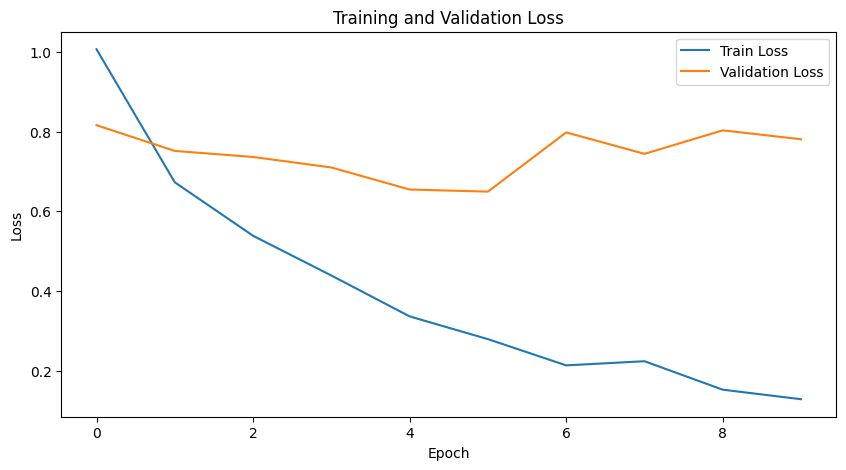

Final Test Accuracy: 78.61%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Load ResNet-18 Model and Modify for CIFAR-10
model = models.resnet18(pretrained=True)  # Use pretrained weights
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify last layer for 10 classes (CIFAR-10)
model = model.to(device)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10  # High initial epochs to allow for early stopping
early_stop_patience = 5  # Early stopping patience for validation loss improvement
min_val_loss = np.Inf
early_stop_counter = 0

train_losses, val_losses = [], []

# Training and Validation Loop with Early Stopping
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter if validation loss improves
        best_model_state = model.state_dict()  # Save best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # Load best model state
            break

# Plot Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Testing the Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
